In [3]:
import math
import meep as mp
from meep import mpb

import numpy as np
import matplotlib.pyplot as plt

In [38]:
#屈折率
n_Air = 1
n_Si = 3.48

#slab厚さ
h = 0.5

#三角形の一辺
s = 0.3

#穴シフト
R = 0.9

#計算する固有周波数の数
num_bands = 6

#メッシュの細かさ
resolution = 32

#計算間隔
interpolate = 4

#-------------------------------------------------------------------#


#単位格子
geometry_lattice = mp.Lattice(size=mp.Vector3(1, 1, 10*h),
                              basis1=mp.Vector3(1./2, np.sqrt(3)/2),
                              basis2=mp.Vector3(1./2, -np.sqrt(3)/2))

tri1 = [mp.Vector3(1,1,0)*s_param,
       mp.Vector3(-1,0,0)*s_param,
       mp.Vector3(0,-1,0)*s_param
      ]

#構造
s_param = s/(np.sqrt(3))
# ▷
tri1 = [
        mp.Vector3(-1,-1)*s_param,
        mp.Vector3(1,0)*s_param,
        mp.Vector3(0,1)*s_param
      ]

# ◁
tri2 = [
        mp.Vector3(1,1)*s_param,
        mp.Vector3(-1,0)*s_param,
        mp.Vector3(0,-1)*s_param
      ]

geometry = [
            mp.Block(material=mp.Medium(epsilon=1),
                        size=mp.Vector3(mp.inf, mp.inf, 10*h)),
            mp.Block(material=mp.Medium(epsilon=n_Si**2),
                        size=mp.Vector3(mp.inf, mp.inf, h)),

            mp.Prism(tri1, center=mp.Vector3(1/3, 1/3)*R, height=h,
                        material=mp.Medium(epsilon=n_Air**2)),
            
            mp.Prism(tri2, center=mp.Vector3(1/3, 0)*R, height=h,
                        material=mp.Medium(epsilon=n_Air**2)),

            mp.Prism(tri1, center=mp.Vector3(0, -1/3)*R, height=h,
                        material=mp.Medium(epsilon=n_Air**2)),

            mp.Prism(tri2, center=mp.Vector3(-1/3, -1/3)*R, height=h,
                        material=mp.Medium(epsilon=n_Air**2)),

            mp.Prism(tri1, center=mp.Vector3(-1/3, 0)*R, height=h,
                        material=mp.Medium(epsilon=n_Air**2)),
    
            mp.Prism(tri2, center=mp.Vector3(0, 1/3)*R, height=h,
                        material=mp.Medium(epsilon=n_Air**2))
]

#ブリルアンゾーン
k_points = [
    mp.Vector3(),               # Gamma
    mp.Vector3(1./2, 0),          # M
    mp.Vector3(1./3, 1./3),    # K
    mp.Vector3(),               # Gamma
]
k_points = mp.interpolate(interpolate, k_points)

In [39]:
#計算
ms = mpb.ModeSolver(
    geometry=geometry,
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands
)

#ms.run_tm(mpb.output_at_kpoint(mp.Vector3(-1./3, 1./3),
#                               mpb.fix_efield_phase,
#                               mpb.output_efield_z))
#tm_freqs = ms.all_freqs
#tm_gaps = ms.gap_list
hfields = []
ms.run_te(mpb.output_at_kpoint(mp.Vector3(), mpb.fix_hfield_phase,get_hfields))

te_freqs = ms.all_freqs
te_gaps = ms.gap_list

Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 32 x 32 x 160.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0.5, 0.866025, 0)
     (0.5, -0.866025, 0)
     (0, 0, 5)
Cell volume = 4.33013
Reciprocal lattice vectors (/ 2 pi):
     (1, 0.57735, -0)
     (1, -0.57735, 0)
     (-0, 0, 0.2)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
     prism, center = (0.3,0.3,0)
          height 0.5, axis (0,0,1), sidewall angle: 0 radians, 3 vertices:
          (0.126795,0.126795,-0.25)
          (0.473205,0.3,-0.25)
          (0.3,0.473205,-0.25)
     prism, center = (0.3,0,0)
          height 0.5, axis (0,0,1), sidewall angle: 0 radians, 3 vertices:
          (0.473205,0.173205,-0.25)
          (0.126795,0,-0.25)
    

epsilon: 1-12.1104, mean 1.81389, harm. mean 1.08322, 8.98254% > 1, 7.32546% "fill"


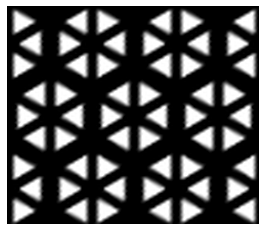

In [47]:
md = mpb.MPBData(rectify=True, periods=3, resolution=32)
eps = ms.get_epsilon()
converted_eps = md.convert(eps)
converted_eps.shape

plt.imshow(converted_eps[:,:,400].T, interpolation='spline36', cmap="binary")
plt.axis('off')
plt.show()

ValueError: num must be 1 <= num <= 12, not 0

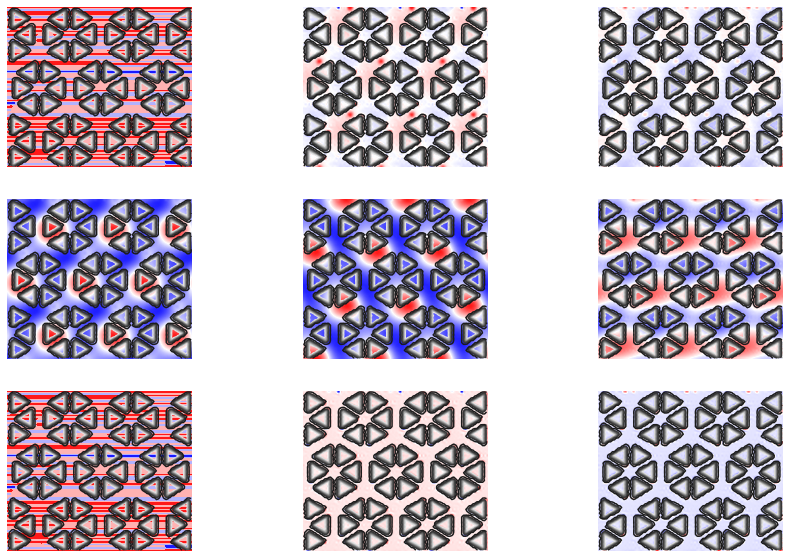

In [43]:
def get_hfields(ms, band):
    hfields.append(ms.get_hfield(band, bloch_phase=True))

#ms.run_te(mpb.output_at_kpoint(mp.Vector3(), mpb.fix_hfield_phase,get_hfields))

# Create an MPBData instance to transform the hfields
md = mpb.MPBData(rectify=True, resolution=32, periods=3)

converted = []
for f in hfields:
    # Get just the z component of the hfields
    f = f[..., 0, 2]
    converted.append(md.convert(f))

plt.figure(figsize=(15,10))

for i, f in enumerate(converted):
    plt.subplot(331 + i)
    plt.contour(converted_eps[:,:,400].T, cmap='binary')
    plt.imshow(np.real(f).T, interpolation='spline36', cmap='bwr', alpha=0.9)
    plt.axis('off')

plt.show()

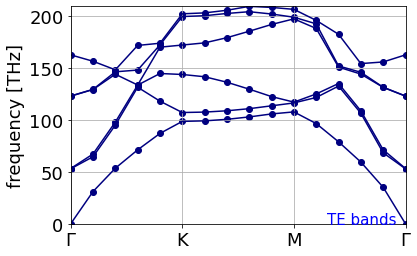

In [45]:
#THz表示
a = 820
c_const = 299792458

fontsize = 18
te_freqs_THz = np.array(te_freqs) * c_const/(a*10**3)
te_gaps_THz = np.array(te_gaps) * c_const/(a*10**3)
#print(te_freqs_THz)

fig, ax = plt.subplots()

x = range(len(te_freqs))

for xz, tez in zip(x, te_freqs_THz):
    ax.scatter([xz]*len(tez), tez, color='navy')

ax.plot(te_freqs_THz, color='navy')
ax.set_ylim([te_freqs_THz.min(), te_freqs_THz.max()])
ax.set_xlim([x[0], x[-1]])

for gap in te_gaps_THz:
    if gap[0] > 1:
        ax.fill_between(x, gap[1], gap[2], color='blue', alpha=0.2)

ax.text(11.5, 0, 'TE bands', color='blue', size=15)

points_in_between = (len(te_freqs) - 4) / 3
tick_locs = [i*points_in_between+i for i in range(4)]
tick_labs = ['Γ', 'K', 'M', 'Γ']
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labs, size=fontsize)
ax.set_ylabel('frequency [THz]', size=fontsize)
plt.tick_params(labelsize=fontsize)
ax.grid(True)

plt.show()